# Libraries Used

In [27]:
import pandas as pd
import tweepy
import requests
import gensim
import gensim.corpora as corpora
import re
import emoji
import nltk
import os
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis
import warnings
from access_token import tokens
from wordcloud import WordCloud
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from pprint import pprint

# Configuring Twitter API

In [2]:
auth = tweepy.OAuthHandler(tokens['api_token'], tokens['api_token_secret'])
auth.set_access_token(tokens['access_token'], tokens['access_token_secret'])
api = tweepy.API(auth, wait_on_rate_limit=True)

# Use Pandas DataFrame to store downloaded tweets

In [3]:
# Collect tweets
# set query 
query = "#trump" + " -filter:retweets"

# set date of which queries were created until
cutoff_date = "2022-03-19"

# get tweets at a specified number
tweets = tweepy.Cursor(api.search_tweets, q=query, lang="en", until=cutoff_date).items(200)

# get tweets information, in a form of date, user, location, text
tweets_list = [[tweet.created_at, tweet.user.screen_name, tweet.user.location, tweet.text] for tweet in tweets]

# convert to dataframe
tweets_df = pd.DataFrame(data=tweets_list, columns=['date', 'user', 'location', 'text'])

In [4]:
tweets_df

,date,user,location,text
0,2022-03-18 23:59:04+00:00,sosajoejr559,Hanford CA,45th President Donald J. Trump to Hold a Rally...
1,2022-03-18 23:59:01+00:00,W_Mead_,,@MarshaBlackburn #trump and the @GOP already t...
2,2022-03-18 23:58:57+00:00,LegalLining,The Big Apple,Russia prepared Trump to be Putin's Puppet for...
3,2022-03-18 23:58:33+00:00,RedCacheONLY,,Alex Jones on why Full Send Podcast Trump Inte...
4,2022-03-18 23:58:00+00:00,Theboveed,,Donald Trump wants his supporters to carry Tru...
...,...,...,...,...
195,2022-03-18 23:01:29+00:00,DorothyBeach,"Ohio, USA",@JudiciaryDems An honor that was not given to ...
196,2022-03-18 23:00:46+00:00,randomtrump1,,Random Trump https://t.co/wIrKt8Vmsq - #random...
197,2022-03-18 23:00:34+00:00,cozharz,Troy,This #atheist murderous KGB #dictator quoted #...
198,2022-03-18 23:00:07+00:00,DemActionToday,,@mazemoore #PutinsPuppet https://t.co/QNNLLMpQ...


In [5]:
tweets_df.to_csv ('test.csv', quotechar='"', encoding='utf8', index = False, header=True)

# Data Cleaning

In [15]:
# # Uncomment the line below if loading from previously saved CSV
tweets_df = pd.read_csv('test.csv', quotechar='"', encoding='utf8')

# Remove hyperlinks
tweets_df['text'] = tweets_df['text'].map(lambda x: re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', x))

# Remove punctuation
tweets_df['text'] = tweets_df['text'].map(lambda x: re.sub('[,\\.!?…]', ' ', x))

# Remove unnecessary line breaks
tweets_df['text'] = tweets_df['text'].map(lambda x: re.sub(r"\n", '', x))

# Convert the titles to lowercase
tweets_df['text'] = tweets_df['text'].map(lambda x: x.lower())

# Remove emojis
tweets_df['text'] = tweets_df['text'].map(lambda x: emoji.demojize(x))

# store the processed tweets to csv
tweets_df.to_csv ('test_cleaned.csv', quotechar='"', encoding='utf8', index = False, header=True)

# Exploration using a word cloud

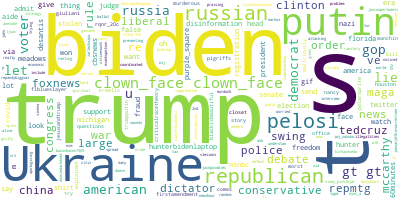

In [17]:
# get all tweets without duplication
unique_tweets = list(set(list(tweets_df['text'].values)))
unique_tweets = [t for t in unique_tweets if t]

# join the words of the different tweets together into one string
long_string = ' '.join(unique_tweets)
new_long_string = ' '.join(set(long_string.split(" ")))

# create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# generate a word cloud
wordcloud.generate(new_long_string)

# visualize the word cloud
wordcloud.to_image()

# Topic Modelling

### Configuring Stopwords

In [21]:
# get stopwords from nltk library, without outputing the download information to terminal
nltk.download('stopwords', quiet=True)

stop_words = stopwords.words('english')

# add more stopwords
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

# get the tweets in a list
data = tweets_df.text.values.tolist()

data_words = list(sent_to_words(data))

# remove stop words
data_words = remove_stopwords(data_words)

### Visualise the topics

In [32]:
# ignore drop warnings for now
warnings.filterwarnings("ignore")

# create a dictionary
id2word = corpora.Dictionary(data_words)

# create a corpus
texts = data_words

# convert the corpus into a BoW representation
corpus = [id2word.doc2bow(text) for text in texts]

# set number of topics
num_topics = 5

# build an LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics)

# print keywords in each topic
# pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./'+str(num_topics))

LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)

# uncomment this if you want to save LDAvis_prepared file
# with open(LDAvis_data_filepath, 'wb') as f:
#     pickle.dump(LDAvis_prepared, f)
# f.close()

# with open(LDAvis_data_filepath, 'rb') as f:
#     LDAvis_prepared = pickle.load(f)
# f.close()

pyLDAvis.save_html(LDAvis_prepared, './saved_topics.html')

LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.053977 -0.125261       1        1  41.989149
1     -0.149489 -0.016482       2        1  20.947329
4      0.035058  0.029115       3        1  17.139486
0      0.027501  0.079755       4        1  11.733938
3      0.032953  0.032873       5        1   8.190099, topic_info=               Term       Freq      Total Category  logprob  loglift
296         ukraine  28.000000  28.000000  Default  30.0000  30.0000
525           aides   9.000000   9.000000  Default  29.0000  29.0000
528             may   6.000000   6.000000  Default  28.0000  28.0000
530        paranoid   6.000000   6.000000  Default  27.0000  27.0000
529            oust   6.000000   6.000000  Default  26.0000  26.0000
..              ...        ...        ...      ...      ...      ...
216            shut   0.553624   1.588287   Topic5  -5.6733   1.4483
242  disinformation   0.553564   1.852265   Topic5  -5.6734   1.2945
305           media   0.553492   2.263142   Topic5  -5.6735   1.0940
925           vegix   0.553426   1.588133   Topic5  -5.6736   1.4481
4         president   0.553425   3.415478   Topic5  -5.6737   0.6823

[298 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
18        4  0.888202       according
740       2  0.778290            acyn
95        1  0.921265  administration
592       2  0.778280              ai
575       2  0.510039            aide
...     ...       ...             ...
63        1  0.568806           would
63        2  0.426604           would
1023      5  0.933025             wsj
576       2  0.778335       yamaguchi
89        1  0.677781             yes

[336 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 5, 1, 4])